# INSTALL

In [41]:
!pip install pycaret

In [42]:
!pip install shap

In [43]:
!pip install statannot

In [44]:
!pip install ydata-profiling

In [45]:
!pip install lightgbm

#IMPORT

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
#pour les analyses statistiques
from scipy.stats import skew
from statannot import add_stat_annotation
from scipy import stats

In [47]:
from ydata_profiling import ProfileReport

In [48]:
from sklearn.model_selection import train_test_split
#pour les différents Scaler
from sklearn.preprocessing import MaxAbsScaler, QuantileTransformer, PowerTransformer, MinMaxScaler, StandardScaler, RobustScaler
#pour les différents modèles de MACHINE LEARNING
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

#pour rééquiliver le dataset
from imblearn.over_sampling import RandomOverSampler, SMOTE


#pour les metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import recall_score, make_scorer

# pour les hyperparamètres
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Pour les explications de modeles
from sklearn.linear_model import LassoCV
import shap
from sklearn.inspection import permutation_importance

Importation du dataset

In [49]:
link = "https://raw.githubusercontent.com/MaskiVal/DataSets/main/kidney_disease.csv"
df= pd.read_csv(link)

#Exploration

In [50]:
# pour voir toutes les colonnes
pd.set_option('display.max_columns', None)

In [51]:
df.head()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,36.0,1.2,NaN,NaN,15.4,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,18.0,0.8,NaN,NaN,11.3,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,53.0,1.8,NaN,NaN,9.6,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,56.0,3.8,111.0,2.5,11.2,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,26.0,1.4,NaN,NaN,11.6,35,7300,4.6,no,no,no,good,no,no,ckd


In [71]:
classification_count = df['classification'].value_counts().reset_index()
classification_count

,index,classification
0,ckd,248
1,notckd,150
2,ckd\t,2


In [52]:
# Renamed columns red_blood_cell, sugar
df.rename(columns={'rbc': 'red_blood_cell', 'su': 'sugar', 'al': 'albumine','pc':'pus_cell','bp':'blood_pressure','sg':'specific_gravity','ba':'bacteria',
                   'bgr':'blood_g_random','bu':'blood_urea','sc':'creatinine','pcv':'packed_cell_vol','wc':'white_cell','rc':'red_cell','htn':'hypertension',
                  'dm':'diabete','cad':'coronary_artery_disease','pe':'pedal_edema','ane':'anemie'}, inplace=True)


In [53]:
# créé une nouvelle colonne qui pour chaque ligne m'indique le nombre de NaN présent
df['nan_count'] = df.isnull().sum(axis=1)

## Valeurs texte à corriger:

In [54]:
# valeurs à corriger dans Diabete :
df.diabete.unique()

array(['yes', 'no', ' yes', '\tno', '\tyes', nan], dtype=object)

pour info : utilise la fonction isinstance pour vérifier si la valeur est une chaîne de caractères (str) avant d'utiliser l'opérateur in. Ainsi, si la valeur est un float, elle sera directement attribuée sans modification

In [55]:
df['diabete'] = df['diabete'].apply(lambda x: 'yes' if isinstance(x, str) and 'yes' in x else ('no' if isinstance(x, str) and 'no' in x else x))

In [56]:
# valeurs à corriger dans coronary_artery_disease
df.coronary_artery_disease.unique()

array(['no', 'yes', '\tno', nan], dtype=object)

In [57]:
df['coronary_artery_disease'] = df['coronary_artery_disease'].apply(lambda x: 'no' if isinstance(x, str) and 'no' in x else x)

## Valeurs numériques à corriger :

In [58]:
# remplacer les valeurs aberrantes dans potassium
df['pot'].replace(47.0 , 4.7, inplace=True)
df['pot'].replace(39.0 , 3.9, inplace=True)

In [59]:
# identifier les erreurs dans packed cell vol :
df.packed_cell_vol.unique()

array(['44', '38', '31', '32', '35', '39', '36', '33', '29', '28', nan,
       '16', '24', '37', '30', '34', '40', '45', '27', '48', '\t?', '52',
       '14', '22', '18', '42', '17', '46', '23', '19', '25', '41', '26',
       '15', '21', '43', '20', '\t43', '47', '9', '49', '50', '53', '51',
       '54'], dtype=object)

In [60]:
# Remplacez les valeurs non numériques par NaN
df['packed_cell_vol'] = pd.to_numeric(df['packed_cell_vol'], errors='coerce')

# Changed wc to dtype float
df['packed_cell_vol'] = df['packed_cell_vol'].astype(float)


In [61]:
# identifier les erreurs
df.white_cell.unique()

array(['7800', '6000', '7500', '6700', '7300', nan, '6900', '9600',
       '12100', '4500', '12200', '11000', '3800', '11400', '5300', '9200',
       '6200', '8300', '8400', '10300', '9800', '9100', '7900', '6400',
       '8600', '18900', '21600', '4300', '8500', '11300', '7200', '7700',
       '14600', '6300', '\t6200', '7100', '11800', '9400', '5500', '5800',
       '13200', '12500', '5600', '7000', '11900', '10400', '10700',
       '12700', '6800', '6500', '13600', '10200', '9000', '14900', '8200',
       '15200', '5000', '16300', '12400', '\t8400', '10500', '4200',
       '4700', '10900', '8100', '9500', '2200', '12800', '11200', '19100',
       '\t?', '12300', '16700', '2600', '26400', '8800', '7400', '4900',
       '8000', '12000', '15700', '4100', '5700', '11500', '5400', '10800',
       '9900', '5200', '5900', '9300', '9700', '5100', '6600'],
      dtype=object)

In [62]:
# Remplacez les valeurs non numériques par NaN
df['white_cell'] = pd.to_numeric(df['white_cell'], errors='coerce')

# Changed wc to dtype float
df['white_cell'] = df['white_cell'].astype(float)

In [63]:
# identifier les erreurs
df.red_cell.unique()

array(['5.2', nan, '3.9', '4.6', '4.4', '5', '4.0', '3.7', '3.8', '3.4',
       '2.6', '2.8', '4.3', '3.2', '3.6', '4', '4.1', '4.9', '2.5', '4.2',
       '4.5', '3.1', '4.7', '3.5', '6.0', '5.0', '2.1', '5.6', '2.3',
       '2.9', '2.7', '8.0', '3.3', '3.0', '3', '2.4', '4.8', '\t?', '5.4',
       '6.1', '6.2', '6.3', '5.1', '5.8', '5.5', '5.3', '6.4', '5.7',
       '5.9', '6.5'], dtype=object)

In [64]:
# Remplacez les valeurs non numériques par NaN
df['red_cell'] = pd.to_numeric(df['red_cell'], errors='coerce')
df['red_cell'] = df['red_cell'].astype(float)

## Analyse des corrélations

In [65]:
df_num= df.select_dtypes(include=['int64', 'float64']).drop(['id','nan_count'], axis=1)

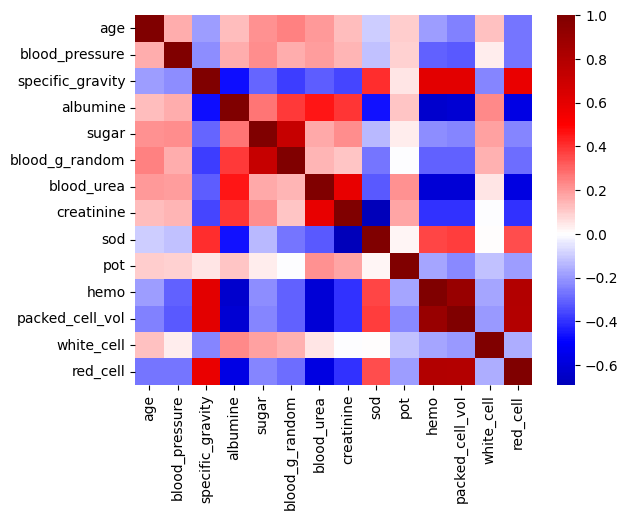

In [66]:
# évalue les corr dans les variables num sans distinction malade / pas malade
sns.heatmap(df_num.corr(), cmap= 'seismic', center= 0)
plt.show()

Transormation des colonnes non mumériques en 0 ou 1 pour étude de corrélation

Les Nan restent en Nan pour l'instant

The non-numerical data are identified and transformed into numbers. The ‘normal’, ‘present’, ‘yes’, and ‘good’ values for nominal attributes are replaced by ‘1’ and ‘abnormal‘, ‘notpresent’, ‘no’, and ‘poor’ values are replaced by ‘0’.

In [67]:
pos_value= ['normal','present','yes','good']
neg_value= ['abnormal','notpresent','no','poor']

In [68]:
# fonction pour transformer les string en numérique :
def transform_non_num(valeur):
    if valeur in pos_value:
        return 1
    elif valeur in neg_value:
        return 0
    else:
        return valeur

In [69]:
df['red_blood_cell']= df['red_blood_cell'].apply(transform_non_num)
df['pus_cell']= df['pus_cell'].apply(transform_non_num)
df['pcc']= df['pcc'].apply(transform_non_num)
df['bacteria']= df['bacteria'].apply(transform_non_num)
df['hypertension']= df['hypertension'].apply(transform_non_num)
df['diabete']= df['diabete'].apply(transform_non_num)
df['coronary_artery_disease']= df['coronary_artery_disease'].apply(transform_non_num)
df['appet']= df['appet'].apply(transform_non_num)
df['pedal_edema']= df['pedal_edema'].apply(transform_non_num)
df['anemie']= df['anemie'].apply(transform_non_num)

In [72]:
# transformer CKD en 1 et notCKD en 0 (quelques valeurs = ckd\t seront convertis en 1 aussi)
# Donc 1 = malade, 0 = pas malade
df['classification']= df['classification'].apply(lambda x : 0 if x == 'notckd' else 1)

In [73]:
df_num2= df.select_dtypes(include=['int64', 'float64']).drop(['id','nan_count'], axis=1)

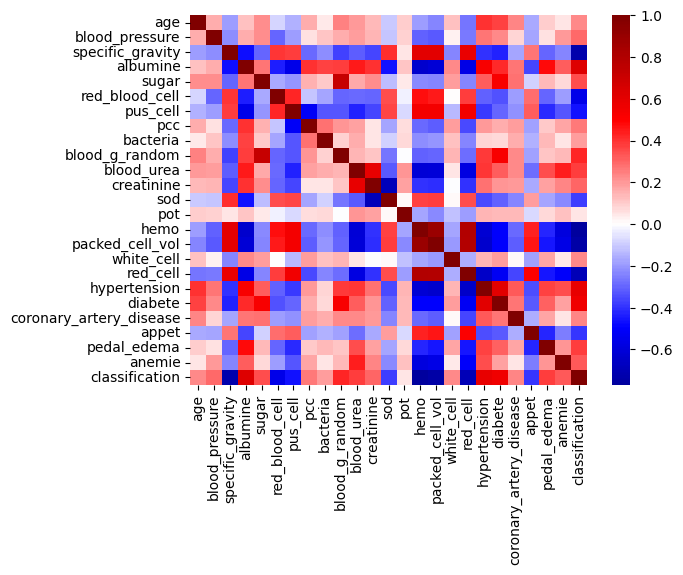

In [74]:
# évalue les corr avec les nouvelles variables num
sns.heatmap(df_num2.corr(), cmap= 'seismic', center= 0)
plt.show()

In [76]:
correlation_matrix= df_num2.corr()

# Tris de la matrice de corrélation par valeur absolue (pour inclure les corrélations négatives)
sorted_corr = correlation_matrix.abs().unstack().sort_values(ascending=False)

# Sélectionner les paires de colonnes avec les corrélations les plus élevées
top_corr_pairs = sorted_corr[sorted_corr < 1].drop_duplicates().head(150)


In [77]:
# afficher les corrélations les plus forte dans un dataframe
corr_df = pd.DataFrame({
    'Variable_1': [pair[0] for pair in top_corr_pairs.index],
    'Variable_2': [pair[1] for pair in top_corr_pairs.index],
    'Correlation': top_corr_pairs.values
})
corr_df.head(10)

,Variable_1,Variable_2,Correlation
0,packed_cell_vol,hemo,0.895382
1,hemo,red_cell,0.798880
2,packed_cell_vol,red_cell,0.791625
3,classification,hemo,0.768919
4,packed_cell_vol,classification,0.741427
5,specific_gravity,classification,0.732163
6,blood_g_random,sugar,0.717827
7,red_cell,classification,0.699089
8,creatinine,sod,0.690158
9,hypertension,red_cell,0.647767


### Variables avec forte corr négative avec malade ou pas (< -0.70)

Specific gravity (urinaire) : -0.73

Hemo (sanguin) : -0.77

packed cell volume (sanguin) : -0.74

red cell (sanguin) : -0.70



### Variable avec corr positive avec la maladie (rien au dessus de 0.70)

Albumine (urinaire) : 0.63

hypertension (autre) : 0.59

diabete (autre) : 0.55

# Remplacement des NaN

## Dataframe avec uniquement des lignes avec Nan

Permet de voir les lignes avec le plus de Nan pour voir lesquelles supprimer

In [78]:
dfna= df[df.isna().any(axis=1)]

In [79]:
# ordonne le dataset avec les lignes comportant le plus de Nan en premier
dfna = dfna.sort_values(by='nan_count', ascending=False, na_position='last')
dfna.head(20)

,id,age,blood_pressure,specific_gravity,albumine,sugar,red_blood_cell,pus_cell,pcc,bacteria,blood_g_random,blood_urea,creatinine,sod,pot,hemo,packed_cell_vol,white_cell,red_cell,hypertension,diabete,coronary_artery_disease,appet,pedal_edema,anemie,classification,nan_count
86,86,56.0,80.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,415.0,37.0,1.9,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,1.0,0.0,0.0,1,11
104,104,55.0,90.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,143.0,88.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,0.0,1.0,0.0,1,11
228,228,60.0,70.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,124.0,52.0,2.5,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,1.0,0.0,0.0,1,11
222,222,74.0,60.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,108.0,68.0,1.8,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,1.0,0.0,0.0,1,11
59,59,59.0,100.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,96.0,6.4,NaN,NaN,6.6,NaN,NaN,NaN,1.0,1.0,0.0,1.0,0.0,1.0,1,11
148,148,69.0,60.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,171.0,26.0,48.1,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,1,11
165,165,60.0,80.0,1.020,0.0,2.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,1.0,0.0,0.0,1,11
30,30,NaN,70.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,93.0,155.0,7.3,132.0,4.9,NaN,NaN,NaN,NaN,1.0,1.0,0.0,1.0,0.0,0.0,1,10
109,109,54.0,70.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,233.0,50.1,1.9,NaN,NaN,11.7,NaN,NaN,NaN,0.0,1.0,0.0,1.0,0.0,0.0,1,10
215,215,2.0,NaN,1.010,3.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,1,10


## Création version dataset avec les lignes à + de 3 valeurs Nan supprimées

ça enlève 127 lignes, majoritairement classifiées en CKD ( valeur la plus présente dans notre dataset)

reste donc 273 lignes avec encore des Nan à remplacer

In [80]:
df_ckd_supp_X3 = df[df['nan_count']<= 3]

In [81]:
df_ckd_supp_X3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 275 entries, 0 to 399
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       275 non-null    int64  
 1   age                      272 non-null    float64
 2   blood_pressure           270 non-null    float64
 3   specific_gravity         273 non-null    float64
 4   albumine                 274 non-null    float64
 5   sugar                    274 non-null    float64
 6   red_blood_cell           216 non-null    float64
 7   pus_cell                 263 non-null    float64
 8   pcc                      272 non-null    float64
 9   bacteria                 272 non-null    float64
 10  blood_g_random           264 non-null    float64
 11  blood_urea               270 non-null    float64
 12  creatinine               272 non-null    float64
 13  sod                      249 non-null    float64
 14  pot                      2

In [82]:
# remplacement par la moyenne pour packed cell volume
# car distribution normale et symétrique

moy= df['packed_cell_vol'].mean()
df['packed_cell_vol']= df['packed_cell_vol'].fillna(moy)

### remplacement par médiane arrondie pile

In [83]:
list_col_round= ['age','blood_pressure','blood_g_random','blood_urea','sod','white_cell']
for col in list_col_round:
    mediane = round(df[col].median())
    df[col]= df[col].fillna(mediane)

### remplacement par médiane arrondie à 2

In [84]:
list_col_round2= ['specific_gravity','creatinine','pot','hemo','red_cell']
for col in list_col_round2:
    mediane = round(df[col].median(),2)
    df[col]= df[col].fillna(mediane)

### remplacement par mode 0 ou 1

colonne avec mode à 0, à remplacer Nan par 0 :


pcc,
bacteria,
coronary_artery_disease,
pedal_edema,
anemie,
diabete,
hypertension

On rajoute 'albumine' et 'sugar' qui ont des valeurs de 0 à 5 mais une très très grande majorité de 0, et il y a qu'une seule valeur manquante.

In [85]:
list_column=['pcc','bacteria','coronary_artery_disease','pedal_edema','anemie','diabete','hypertension','albumine','sugar']
for column in list_column:
    df_ckd_supp_X3[column]= df_ckd_supp_X3[column].fillna(0)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


colonne avec mode à 1, à remplacer Nan par 1:


red_blood_cell,
pus_cell,
appet

In [86]:
list_column2= ['red_blood_cell','pus_cell','appet']
for column in list_column2:
    df_ckd_supp_X3[column]= df_ckd_supp_X3[column].fillna(1)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [87]:
df_ckd_supp_X3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 275 entries, 0 to 399
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       275 non-null    int64  
 1   age                      272 non-null    float64
 2   blood_pressure           270 non-null    float64
 3   specific_gravity         273 non-null    float64
 4   albumine                 275 non-null    float64
 5   sugar                    275 non-null    float64
 6   red_blood_cell           275 non-null    float64
 7   pus_cell                 275 non-null    float64
 8   pcc                      275 non-null    float64
 9   bacteria                 275 non-null    float64
 10  blood_g_random           264 non-null    float64
 11  blood_urea               270 non-null    float64
 12  creatinine               272 non-null    float64
 13  sod                      249 non-null    float64
 14  pot                      2

In [88]:
# extraction du fichier csv depuis ce dataset :
# à nommer comme vous voulez
df_ckd_supp_X3.to_csv('df_ckd_supp_X3.csv', index = False)

# Création version dataset avec les lignes à + de 7 valeurs Nan supprimées

ça enlève 31 lignes, majoritairement classifiées en CKD ( valeur la plus présente dans notre dataset)
reste donc 369 lignes avec encore des Nan à remplacer

In [89]:
df_ckd_7XNan_supp = df[df['nan_count']<= 7]

In [90]:
df_ckd_7XNan_supp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 369 entries, 0 to 399
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       369 non-null    int64  
 1   age                      369 non-null    float64
 2   blood_pressure           369 non-null    float64
 3   specific_gravity         369 non-null    float64
 4   albumine                 342 non-null    float64
 5   sugar                    341 non-null    float64
 6   red_blood_cell           245 non-null    float64
 7   pus_cell                 325 non-null    float64
 8   pcc                      365 non-null    float64
 9   bacteria                 365 non-null    float64
 10  blood_g_random           369 non-null    float64
 11  blood_urea               369 non-null    float64
 12  creatinine               369 non-null    float64
 13  sod                      369 non-null    float64
 14  pot                      3

In [91]:
# extraction du fichier csv depuis ce dataset :
# à nommer comme vous voulez ...
df_ckd_7XNan_supp.to_csv('df_ckd_7XNan_supp.csv', index = False)

#ML sur dataset

In [102]:
df = pd.read_csv('/content/df_ckd_7 (1).csv')

##Pycaret

In [103]:
from pycaret.classification import *

In [104]:
clf1 = setup(data=df, target='classification')

,Description,Value
0,Session id,3810
1,Target,classification
2,Target type,Binary
3,Original data shape,"(369, 27)"
4,Transformed data shape,"(369, 27)"
5,Transformed train set shape,"(258, 27)"
6,Transformed test set shape,"(111, 27)"
7,Numeric features,26
8,Preprocess,True
9,Imputation type,simple


In [105]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0370
rf,Random Forest Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.1480
ada,Ada Boost Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0260
gbc,Gradient Boosting Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0790
et,Extra Trees Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.1160
lr,Logistic Regression,0.9962,1.0000,1.0000,0.9941,0.9970,0.9917,0.9920,0.3750
xgboost,Extreme Gradient Boosting,0.9962,1.0000,1.0000,0.9938,0.9968,0.9920,0.9923,0.0460
lightgbm,Light Gradient Boosting Machine,0.9962,1.0000,0.9938,1.0000,0.9968,0.9920,0.9923,0.3560
lda,Linear Discriminant Analysis,0.9923,1.0000,0.9871,1.0000,0.9933,0.9842,0.9848,0.0250
ridge,Ridge Classifier,0.9885,0.0000,0.9808,1.0000,0.9899,0.9766,0.9779,0.0250


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

##Choix des variables

### 13 variables choisies pour X

In [106]:
X = df[['hemo','packed_cell_vol','red_blood_cell', 'blood_g_random','sod','albumine','sugar','blood_urea', 'hypertension','age','blood_pressure','diabete']]
y = df['classification']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size = 0.75)

In [107]:
print("The length of the initial dataset is :", len(X))
print("The length of the train dataset is   :", len(X_train))
print("The length of the test dataset is    :", len(X_test))

The length of the initial dataset is : 369
The length of the train dataset is   : 276
The length of the test dataset is    : 93


##Test des performances des modèles de machine learning avec leur scaler

In [108]:
#listes

##liste des Scalers utilisés
list_scalers = [
    MaxAbsScaler(),
    QuantileTransformer(),
    PowerTransformer(),
    MinMaxScaler(),
    StandardScaler(),
    RobustScaler()
]
##liste des modèles utilisés
list_models = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    LogisticRegression(),
    ExtraTreesClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    AdaBoostClassifier(),
    XGBClassifier(),
    LGBMClassifier(verbose=-1),
    LinearSVC(),
    NuSVC(),
    SVC(),
    GaussianNB()
]

In [109]:
#double boucle pour classer les modèles de ML selon les résultats des metrics
results = []
for model in list_models:
    """
    Boucle for pour tester un à un les modèles et obtenir leurs metrics
    """
    for scaler in list_scalers:
        """
        Pour chaque modèle, boucle for qui test un à un les scalers
        """
        X_train_scaled = scaler.fit_transform(X_train)
        model.fit(X_train_scaled, y_train)
        X_test_scaled = scaler.transform(X_test)

        #metrics
        accuracy_train = model.score(X_train_scaled, y_train)
        accuracy_test = model.score(X_test_scaled, y_test)

        y_pred_test = model.predict(X_test_scaled)

        recall_test = recall_score(y_test, y_pred_test)
        overfitting = (model.score(X_train_scaled, y_train) - model.score(X_test_scaled, y_test))

        #cross validation
        scores = cross_val_score(model, X_train_scaled, y_train, scoring='recall', cv=5)
        avg_scores = scores.mean()

        confusion_mat = confusion_matrix(y_test, y_pred_test)
        matrice = pd.DataFrame(data = confusion_mat,
                 index = model.classes_ ,
                 columns = model.classes_)

        results.append((model.__class__.__name__, scaler.__class__.__name__, accuracy_train, accuracy_test, recall_test, overfitting, avg_scores, matrice))

#tris de la liste results en fonction de la moyenne des scores de cross_validation, puis du recall_test, puis de l'accuracy test
sorted_results = sorted(results, key=lambda x: (x[6], x[4], x[3]), reverse=True)

#afficher les metrics pour chaque couple Modèle-Scaler
for model, scaler, accuracy_train, accuracy_test, recall_test, overfitting, avg_scores, matrice in sorted_results:
    print("___________________________")
    print(f"Model: {model}")
    print(f"Scaler: {scaler}")
    print(f"Avg scores - cross validation : {avg_scores}")
    print(f"Accuracy Train: {accuracy_train}")
    print(f"Accuracy Test: {accuracy_test}")
    print(f"Recall Test: {recall_test}")
    print(f"Overfitting: {overfitting}")
    print(matrice)

___________________________
Model: RandomForestClassifier
Scaler: QuantileTransformer
Avg scores - cross validation : 0.975189393939394
Accuracy Train: 1.0
Accuracy Test: 0.989247311827957
Recall Test: 1.0
Overfitting: 0.010752688172043001
    0   1
0  34   1
1   0  58
___________________________
Model: RandomForestClassifier
Scaler: PowerTransformer
Avg scores - cross validation : 0.975189393939394
Accuracy Train: 1.0
Accuracy Test: 0.989247311827957
Recall Test: 1.0
Overfitting: 0.010752688172043001
    0   1
0  34   1
1   0  58
___________________________
Model: RandomForestClassifier
Scaler: MinMaxScaler
Avg scores - cross validation : 0.975189393939394
Accuracy Train: 1.0
Accuracy Test: 0.989247311827957
Recall Test: 1.0
Overfitting: 0.010752688172043001
    0   1
0  34   1
1   0  58
___________________________
Model: RandomForestClassifier
Scaler: StandardScaler
Avg scores - cross validation : 0.975189393939394
Accuracy Train: 1.0
Accuracy Test: 0.989247311827957
Recall Test: 1.0

##Cross Validation sur le ExtraTreeClassifier

In [110]:
scaler = MaxAbsScaler()
X_train_scal= scaler.fit_transform(X_train)
X_test_scal= scaler.transform(X_test)

In [111]:
metrics = cross_val_score(ExtraTreesClassifier(), X_train_scal, y_train, cv=5, scoring='recall')
metrics

array([1.     , 1.     , 0.96875, 0.96875, 0.9375 ])

In [112]:
metrics.mean()

0.975

In [113]:
metrics.std()

0.023385358667337135

## Randomizedsearch sur ExtraTreeClassifier

In [114]:
dico = {'max_depth' : range(1,51), 'min_samples_leaf' : range(1,16), 'min_samples_split' : [2,5,7,10,15,30]}
rando = RandomizedSearchCV(ExtraTreesClassifier(), dico ,n_iter= 100, cv=5)
rando.fit(X_train_scal,y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=ExtraTreesClassifier(bootstrap=False,
                                                  ccp_alpha=0.0,
                                                  class_weight=None,
                                                  criterion='gini',
                                                  max_depth=None,
                                                  max_features='sqrt',
                                                  max_leaf_nodes=None,
                                                  max_samples=None,
                                                  min_impurity_decrease=0.0,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  monotonic_cst=None,
                                                  n_estimators=100, n_jobs=None,
                                                  oob_score=False,
                                                  random_state=None, verbose=0,
                                                  warm_start=False),
                   n_iter=100, n_jobs=None,
                   param_distributions={'max_depth': range(1, 51),
                                        'min_samples_leaf': range(1, 16),
                                        'min_samples_split': [2, 5, 7, 10, 15,
                                                              30]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [115]:
print("best score:",rando.best_score_)
print("best parameters:",rando.best_params_)
print("best estimator:",rando.best_estimator_)

best score: 0.9855194805194806
best parameters: {'min_samples_split': 15, 'min_samples_leaf': 1, 'max_depth': 22}
best estimator: ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=22, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_samples_leaf=1,
                     min_samples_split=15, min_weight_fraction_leaf=0.0,
                     monotonic_cst=None, n_estimators=100, n_jobs=None,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)


Ne pas prendre les best parametres pour ce DF sinon les scores seront tous à 1

##Modele ExtraTreeClassifier

In [116]:
modelETC= ExtraTreesClassifier()
modelETC.fit(X_train_scal, y_train)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     monotonic_cst=None, n_estimators=100, n_jobs=None,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [117]:
# résultat avec best scaler, best model et best paramètre :
print(' accuracy score Train: ', modelETC.score(X_train_scal, y_train))
print(' accuracy score Test: ', modelETC.score(X_test_scal, y_test))

 accuracy score Train:  1.0
 accuracy score Test:  0.978494623655914


In [118]:
y_pred_test = modelETC.predict(X_test_scal)

In [119]:
recall_test = recall_score(y_test, y_pred_test)
recall_test

0.9655172413793104

In [120]:
confusion_mat = confusion_matrix(y_test, y_pred_test)
matrice = pd.DataFrame(data = confusion_mat,
                 index = modelETC.classes_ ,
                 columns = modelETC.classes_)
matrice

,0,1
0,35,0
1,2,56


## PREDICTIONS

In [121]:
a = 15.8
b= 1.1
c= 141
d= 53
e= 6.1
f= 18
g= 131
h= 0
i= 0
j= 0
k= 0
l= 58
m= 80

In [122]:
my_data = np.array([a,b,c,d,e,f,g,h,i,j,k,l,m]).reshape(1,13)

In [123]:
modelRein= ExtraTreesClassifier()
scal_rein= MaxAbsScaler()
X = df[['hemo','creatinine','sod','packed_cell_vol','red_blood_cell','blood_urea','blood_g_random',
                     'sugar','albumine', 'hypertension','diabete','age','blood_pressure']]
y = df['classification']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size = 0.75)
X_train_scal= scal_rein.fit_transform(X_train)
X_test_scal= scal_rein.transform(X_test)
modelRein.fit(X_train_scal, y_train)
rein_data = pd.DataFrame(my_data,
                    columns= ['hemo','creatinine','sod','packed_cell_vol','red_blood_cell','blood_urea','blood_g_random',
                     'sugar','albumine', 'hypertension','diabete','age','blood_pressure'])
rein_data_scal = scal_rein.transform(rein_data)
rein_predict = modelRein.predict(rein_data_scal)

In [124]:
int(rein_predict)

0

#Explications du modèle de ML sélectionné

## Feature Importance

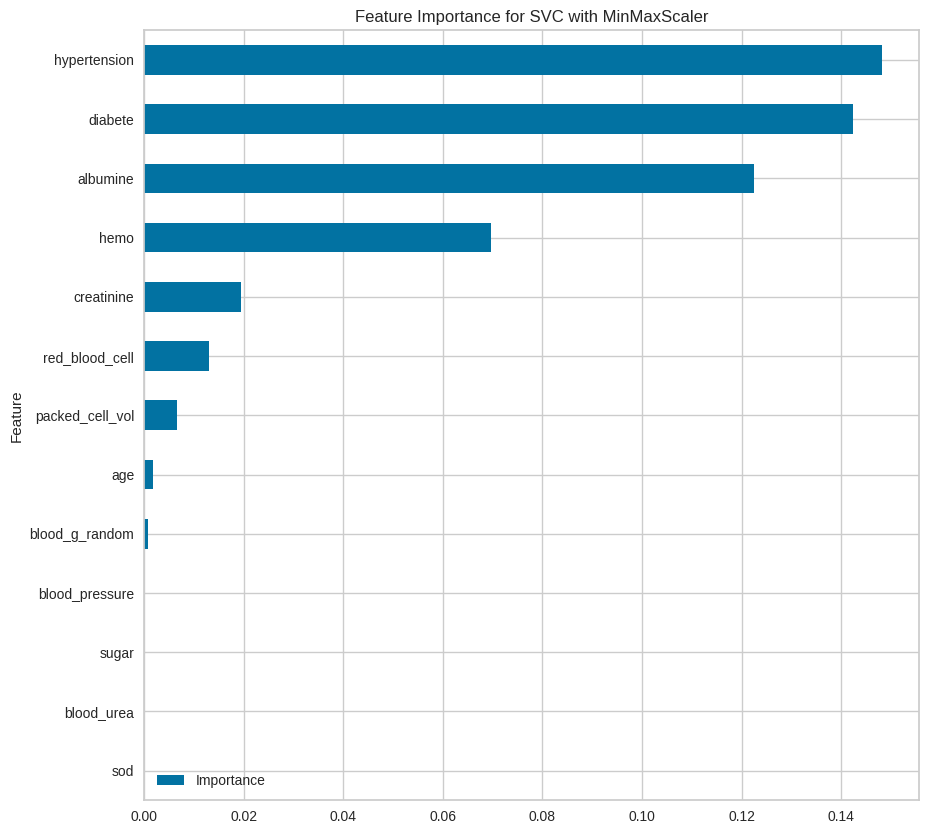

In [125]:
result = permutation_importance(modelRein, X_train_scal, y_train, n_repeats=10, random_state=42)

feature_importance_svc = pd.DataFrame({'Feature': X.columns, 'Importance': result.importances_mean})
feature_importance_svc = feature_importance_svc.sort_values('Importance', ascending=True)

feature_importance_svc.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 10))
plt.title('Feature Importance for SVC with MinMaxScaler')
plt.show()

##LASSO

In [126]:
reg = LassoCV()
reg.fit(X_train_scal, y_train)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, positive=False,
        precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
        verbose=False)

In [127]:
#print("Best alpha using built-in LassoCV: %f" % reg.alphas_)
print("Best score using built-in LassoCV: %f" %reg.score(X_train_scal,y_train))
coef = pd.Series(reg.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Best score using built-in LassoCV: 0.693223
Lasso picked 6 variables and eliminated the other 7 variables


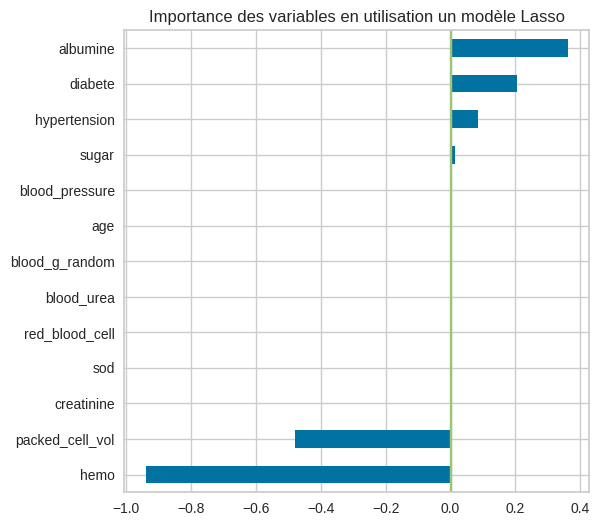

In [128]:
fig = plt.figure(figsize=(6,6))
imp_coef = coef.sort_values()
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.axvline(x=0, color='g')
plt.title("Importance des variables en utilisation un modèle Lasso")
fig.savefig('importance_graph.png', dpi=200, bbox_inches = 'tight') ;

## SHAP

In [129]:
# Convertir le résultat en DataFrame avec les noms de colonnes
X_test_shape = pd.DataFrame(X_test_scal, columns=list(X_test.columns))
X_train_shape = pd.DataFrame(X_train_scal, columns=list(X_train.columns))

In [131]:
explainer = shap.KernelExplainer(modelRein.predict,shap.sample(X_test_shape,100))

In [132]:
shap_values = explainer.shap_values(X_test_shape,nsamples=100)

  0%|          | 0/93 [00:00<?, ?it/s]

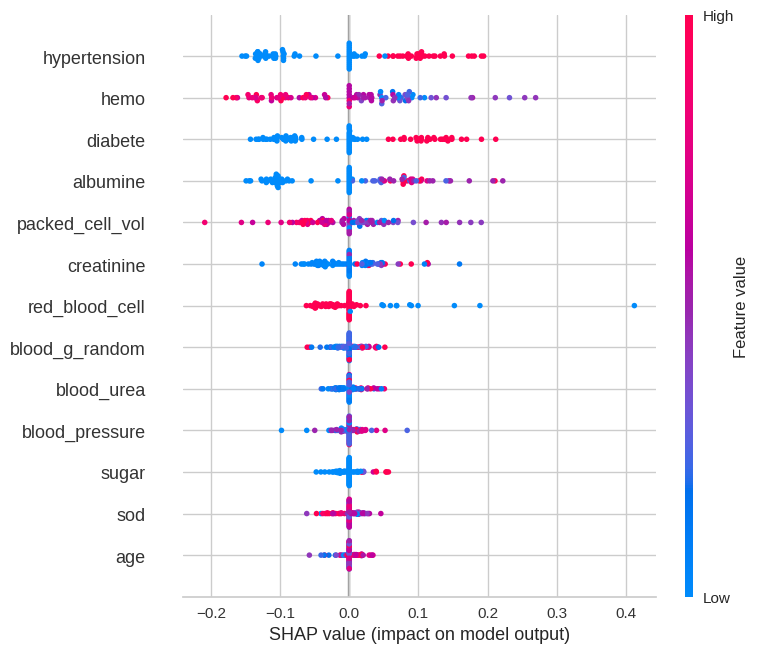

In [133]:
shap.summary_plot(shap_values,X_test_shape)